# PV flux, EKE and integral timescale as a function of slope

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import SymmetricalLogLocator, NullFormatter
import cmocean as cmo
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
def addTicks(ax,base,linthresh):
    ax.xaxis.set_major_locator(SymmetricalLogLocator(base=base, linthresh=linthresh))
    subs = np.arange(2, 10) * 0.1
    ax.xaxis.set_minor_locator(SymmetricalLogLocator(base=base, subs=subs, linthresh=linthresh))
    ax.xaxis.set_minor_formatter(NullFormatter())

    # Filter out ticks inside the linear region
    major_ticks = [t for t in ax.get_xticks() if abs(t) >= linthresh]
    minor_ticks = [t for t in ax.get_xticks(minor=True) if abs(t) >= linthresh]

    major_ticks.extend([-linthresh, linthresh])
    major_ticks = sorted(set(major_ticks))  # remove duplicates and sort

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.tick_params(which="both", bottom=True)

In [3]:
g = 9.81
f0 = 1e-4
rho1 = 1027.6
rho2 = 1028
gp = g*(rho2-rho1)/rho2
H1 = 1000
H2 = 4000
U = 0.2
alpha_c = f0*U/gp

In [ ]:
# PV fluxes

def eulerianPVflux(slope,layer,field):
    flux = pd.read_csv('../../Results/Results_Diffusivities/SmallLd/eulerian/simulation_s'+slope+'_field'+field+'_layer'+layer+'_flux.csv')
    return flux

def lagrangianPVflux(slope,layer,field):
    flux = pd.read_csv('../../Results/Results_Diffusivities/SmallLd/lagrangian/simulation_s'+slope+'_field'+field+'_1hr12hr_layer'+layer+'_flux.csv')
    return flux


flux_dict = {'lagrangian': lagrangianPVflux,
            'eulerian': eulerianPVflux}

def averagePVflux(slope,layer,field,obstype):
    if field=='all': # consider all fields
        flux_1 = flux_dict[obstype](slope,layer,'1')
        flux_2 = flux_dict[obstype](slope,layer,'2')
        flux_3 = flux_dict[obstype](slope,layer,'3')
        flux = pd.concat([flux_1,flux_2,flux_3],axis=0)
    else: # consider only one field
        flux = flux_dict[obstype](slope,layer,field)
    limflux = np.nanmean(flux.to_numpy()) # average over all times
    limstd = np.nanstd(flux.to_numpy()) # standard deviation over all times
    return limflux*-1, limstd

In [5]:
# EKE

# Lagrangian - from particles
def lagrangianEKE(slope,layer,field):
    vsqrd = pd.read_csv('../../Results/Results_EKE/SmallLd/lagrangian/simulation_s'+slope+'_strongmu_field'+field+'_eke_v_layer'+layer+'_1hr12hr_highqfilter.csv')
    return vsqrd

# Eulerian - from flow fields
def eulerianEKE(slope,layer,field):
    vsqrd = pd.read_csv('../../Results/Results_EKE/SmallLd/eulerian/simulation_s'+slope+'_field'+field+'_layer'+layer+'_eke_v.csv')
    return vsqrd


eke_dict = {'lagrangian': lagrangianEKE,
            'eulerian': eulerianEKE}

def averageEKE(slope,layer,field,obstype):
    if field=='all': # average over all fields
        eke_1 = eke_dict[obstype](slope,layer,'1')
        eke_2 = eke_dict[obstype](slope,layer,'2')
        eke_3 = eke_dict[obstype](slope,layer,'3')
        eke = pd.concat([eke_1, eke_2, eke_3], axis=0)
    else: # consider only one field
        eke = eke_dict[obstype](slope,layer,field)
    limeke = np.nanmean(eke.to_numpy()) # average over all days over all particle runs
    limstd = np.nanstd(eke.to_numpy()) # standard deviation over all days over all particle runs
    return limeke, limstd

In [6]:
# Integral timescale

def load_Tint(slope,layer,field):
    acov_fname = '../../Results/Results_Diffusivities/SmallLd/lagrangian/autocovariance_v_s'+slope+'_layer'+layer+'_field'+field+'_1hr12hr_biased_highqfilter.csv'
    acov = pd.read_csv(acov_fname)
    diff_fname = '../../Results/Results_Diffusivities/SmallLd/lagrangian/acov_diff_s'+slope+'_layer'+layer+'_field'+field+'_1hr12hr_biased_highqfilter.csv'
    diff = pd.read_csv(diff_fname)
    tint = diff.divide(acov.iloc[:, 0], axis=0)
    return tint/86400  # convert from seconds to days

def limitTint_av(slope,layer,field,days=100,run=None):
    if field=='all': # consider all fields
        tint_1 = load_Tint(slope,layer,'1')
        tint_2 = load_Tint(slope,layer,'2')
        tint_3 = load_Tint(slope,layer,'3')
        tint = pd.concat([tint_1,tint_2,tint_3],axis=0)
        tint_end = tint.iloc[:,int(-days*2):]
    elif run==None: # consider only one field, average over all runs
        tint = load_Tint(slope,layer,field)
        tint_end = tint.iloc[:,int(-days*2):]
    else: # consider only one field and one particle run
        tint = load_Tint(slope,layer,field).iloc[run]
        tint_end = tint.iloc[int(-days*2):]
    limtint = np.nanmean(tint_end.to_numpy()) # average over last X days over all particle runs
    limstd = np.nanstd(tint_end.to_numpy())
    return limtint, limstd

In [25]:
slopes = ['-3e-3','-2e-3','-1e-3','-7e-4','-5e-4','-3e-4','-2e-4','-1e-4',
          '0','1e-4','2e-4','3e-4','5e-4','7e-4','1e-3','2e-3','3e-3','5e-3','7e-3']
slopes_float = [float(s) for s in slopes]

def flux_vs_slope(layer,field,ax,show_err=True,logscale=False):
    """
    Plot average flux as a function of slope
    """
    ax.axvline(0,color='k',linestyle=':')
    flux_lagrangian = []
    flux_lagrangian_std = []
    flux_eulerian = []
    flux_eulerian_std = []
    for slope in slopes:
        flux, std = averagePVflux(slope,layer,field,'lagrangian')
        flux_lagrangian.append(flux*1e6)
        flux_lagrangian_std.append(std*1e6)
        flux, std = averagePVflux(slope,layer,field,'eulerian')
        flux_eulerian.append(flux*1e6)
        flux_eulerian_std.append(std*1e6)
    if show_err:
        ax.errorbar(slopes_float,flux_lagrangian,yerr=flux_lagrangian_std,capsize=2,marker='o',color='r',ecolor=mcolors.to_rgba('r',0.5),label=r'Lagrangian')
        ax.errorbar(slopes_float,flux_eulerian,yerr=flux_eulerian_std,capsize=2,marker='o',color='k',ecolor=mcolors.to_rgba('k',0.5),label=r'Eulerian',linestyle='dashed')
    else:
        ax.errorbar(slopes_float,flux_lagrangian,yerr=flux_lagrangian_std,capsize=2,marker='o',color='r',ecolor=mcolors.to_rgba('r',0.25),label=r'Lagrangian')
        ax.errorbar(slopes_float,flux_eulerian,yerr=flux_eulerian_std,capsize=2,marker='o',color='k',ecolor=mcolors.to_rgba('k',0.5),label=r'Eulerian',linestyle='dashed')
    ax.legend()
    ax.set_xlabel(r'Bottom slope $\alpha$')
    ax.set_ylabel(r'Cross-stream PV flux ($10^{-6}$ m/s$^2$)')
    if logscale:
        ax.set_yscale('log')
    ax.set_xscale('symlog', linthresh=1e-4, linscale=0.25)
    addTicks(ax,10,1e-4)
    ax.set_xlim(-1e-2, 1e-2)
    


def eke_vs_slope(layer,field,ax,show_err=True):
    """
    Plot average EKE as a function of slope
    """
    ax.axvline(0,color='k',linestyle=':')
    eke_lagrangian = []
    eke_lagrangian_std = []
    eke_eulerian = []
    eke_eulerian_std = []
    for slope in slopes:
        eke, std = averageEKE(slope,layer,field,'lagrangian')
        eke_lagrangian.append(eke)
        eke_lagrangian_std.append(std)
        eke, std = averageEKE(slope,layer,field,'eulerian')
        eke_eulerian.append(eke)
        eke_eulerian_std.append(std)
    if show_err:
        ax.errorbar(slopes_float,eke_lagrangian,yerr=eke_lagrangian_std,capsize=2,marker='o',label='Lagrangian',color='r',ecolor=mcolors.to_rgba('r',0.5))
        ax.errorbar(slopes_float,eke_eulerian,yerr=eke_eulerian_std,capsize=2,marker='o',label='Eulerian',color='k',ecolor=mcolors.to_rgba('k',0.5),linestyle='dashed')
    else:
        ax.plot(slopes_float,eke_lagrangian,marker='o',label='Lagrangian',color='r')
        ax.plot(slopes_float,eke_eulerian,marker='o',label='Eulerian',color='k')
    ax.legend()
    ax.set_xlabel(r'Bottom slope $\alpha$')
    ax.set_ylabel(r'Cross-stream EKE (m$^2$/s$^2$)')
    ax.set_xscale('symlog', linthresh=1e-4, linscale=0.25)
    addTicks(ax,10,1e-4)
    ax.set_xlim(-1e-2, 1e-2)


def tint_vs_slope(layer,field,ax,days=100,show_err=True,incl_field_title=False):
    """
    Plot average integral timescale as a function of slope
    """
    ax.axvline(0,color='k',linestyle=':')
    tint_lagr = []
    tint_lagr_std = []
    for slope in slopes:
        tint, std = limitTint_av(slope,layer,field)
        tint_lagr.append(tint)
        tint_lagr_std.append(std)
    if show_err:
        ax.errorbar(slopes_float,tint_lagr,yerr=tint_lagr_std,capsize=2,marker='o',label='Lagrangian',color='r',ecolor=mcolors.to_rgba('r',0.5))
    else:
        ax.plot(slopes_float,tint_lagr,marker='o',label='Lagrangian',color='r')
    ax.set_xlabel(r'Bottom slope $\alpha$')
    ax.set_ylabel(r'Lagrangian integral timescale (days)')
    ax.set_xscale('symlog', linthresh=1e-4, linscale=0.25)
    addTicks(ax,10,1e-4)
    ax.set_xlim(-1e-2, 1e-2)

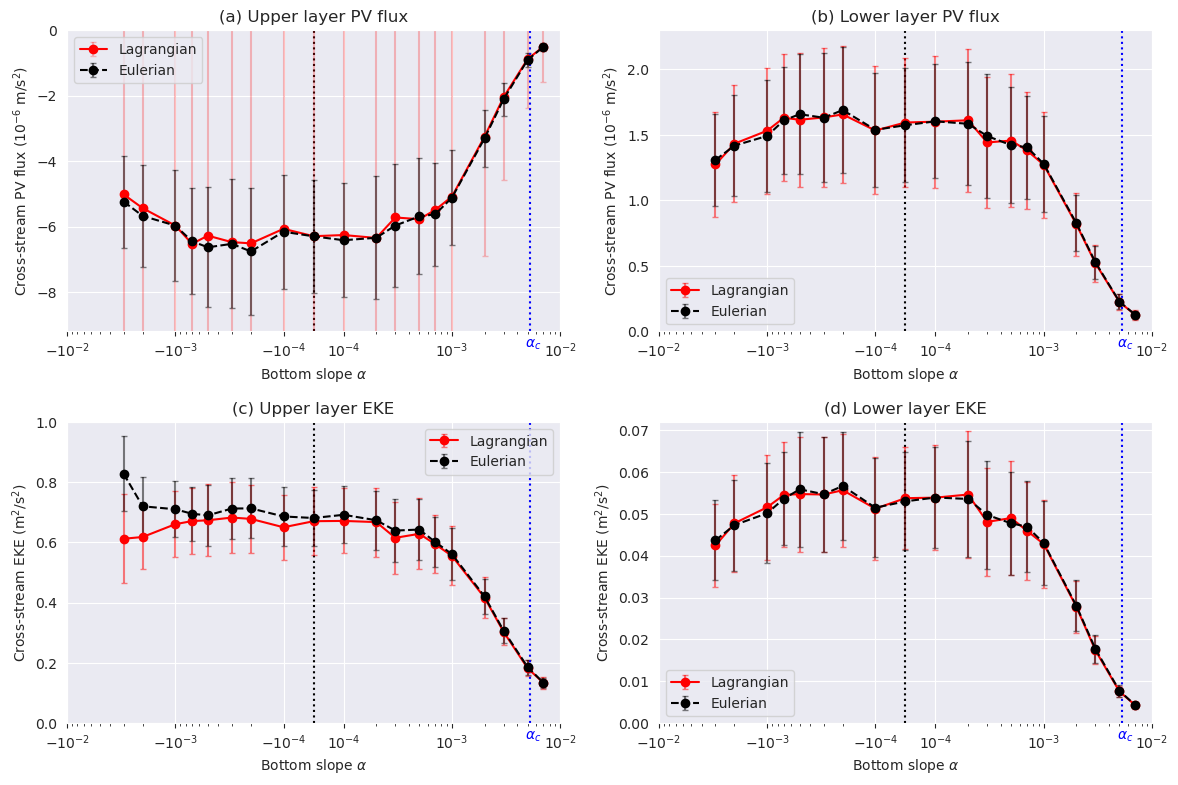

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(14,9))

field = 'all'
flux_vs_slope('1',field,ax1,show_err=False)
flux_vs_slope('2',field,ax2)
eke_vs_slope('1',field,ax3)
eke_vs_slope('2',field,ax4)

ax1.set_title('(a) Upper layer PV flux')
ax2.set_title('(b) Lower layer PV flux')
ax3.set_title('(c) Upper layer EKE')
ax4.set_title('(d) Lower layer EKE')

ax1.set_ylim(-9.2,0)
ax1.text(alpha_c-5e-4,-9.7,r'$\alpha_c$',color='b')
ax1.vlines(alpha_c,ax1.get_ylim()[0],ax1.get_ylim()[1],color='b',linestyle=':')

ax2.set_ylim(0,2.3)
ax2.text(alpha_c-5e-4,-0.12,r'$\alpha_c$',color='b')
ax2.vlines(alpha_c,ax2.get_ylim()[0],ax2.get_ylim()[1],color='b',linestyle=':')

ax3.set_ylim(0,1)
ax3.text(alpha_c-5e-4,-0.055,r'$\alpha_c$',color='b')
ax3.vlines(alpha_c,ax3.get_ylim()[0],ax3.get_ylim()[1],color='b',linestyle=':')

ax4.set_ylim(0,0.072)
ax4.text(alpha_c-5e-4,-0.004,r'$\alpha_c$',color='b')
ax4.vlines(alpha_c,ax4.get_ylim()[0],ax4.get_ylim()[1],color='b',linestyle=':')

plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.savefig('../../Figures/flux_eke_vs_slope.pdf',bbox_inches='tight')
plt.show()

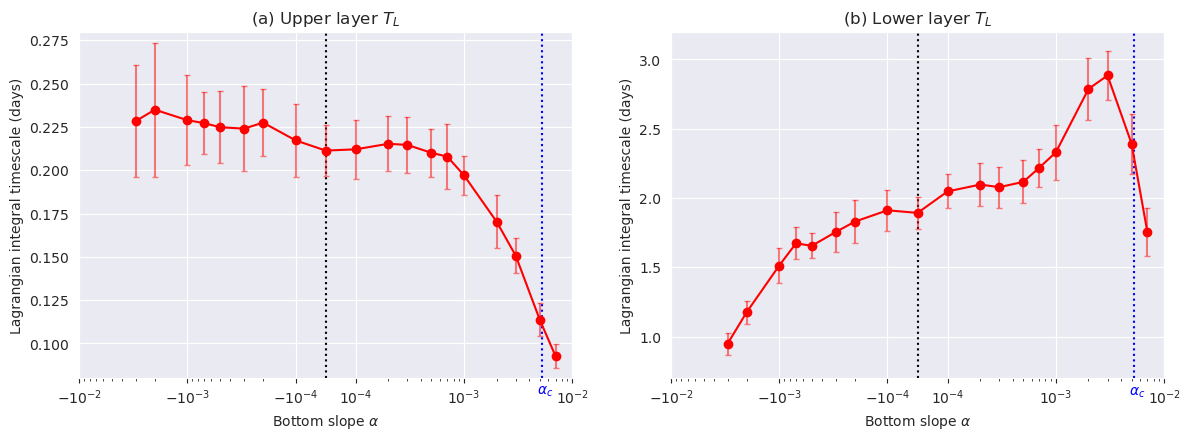

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4.5))

field = 'all'
tint_vs_slope('1',field,ax1)
tint_vs_slope('2',field,ax2)

ax1.set_title('(a) Upper layer $T_L$')
ax2.set_title('(b) Lower layer $T_L$')

ax1.set_ylim(0.08,0.28)
ax1.text(alpha_c-5e-4,0.071,r'$\alpha_c$',color='b')
ax1.vlines(alpha_c,ax1.get_ylim()[0],ax1.get_ylim()[1],color='b',linestyle=':')

ax2.set_ylim(0.7,3.2)
ax2.text(alpha_c-5e-4,0.58,r'$\alpha_c$',color='b')
ax2.vlines(alpha_c,ax2.get_ylim()[0],ax2.get_ylim()[1],color='b',linestyle=':')

plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.savefig('../../Figures/Tint_vs_slope.pdf',bbox_inches='tight')
plt.show()